# Imports

In [1]:
#imports
import numpy as np
import pandas as pd

import os
import tensorflow as tf

import cv2
# import imghdr #pathlib is newer aleternative
import pathlib

from matplotlib import pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

from tensorflow.keras.applications import DenseNet201
from tensorflow.keras import layers

from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import load_model

# 1. Data Load

Label Key: 
0 - Healthy 
, 1 - Low Risk
, 2 - High Risk/ Severe case

In [2]:
#set path of train dataset
train_path = '../Data/Raw Data/train'
val_path =  '../Data/Raw Data/val'
test_path =  '../Data/Raw Data/test'
# target_labels=['Healthy', 'Low-Risk', 'High-Risk or Severe Damage']

In [3]:
#loop through training images for quality control
valid_image_exts = ['.jpeg','.jpg', '.bmp', '.png']

#lopp through the train folder and use subfolder names as image_label
for image_label in os.listdir(train_path): 
    for image in os.listdir(os.path.join(train_path, image_label)):
        image_path = os.path.join(train_path, image_label, image)
        try: 
            training_images = cv2.imread(image_path) #read image
#             tip = imghdr.what(image_path) #check quality
            tip = pathlib.Path(image).suffix #check quality
            if tip not in valid_image_exts:  #quality fail
                print('Image not in ext list {}'.format(image_path))
                # os.remove(image_path) #delete file
        except Exception as e: 
            print('Issue with image {}'.format(image_path))

In [4]:
#Confirming shape of input images as 224 x 224 with BGR colorscale(default color scale of opencv) 
training_images.shape

(224, 224, 3)

In [6]:
#loading training images into a tensor/ prefetch dataset
image_size = (224, 224)
batch_size = 32

training_data = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=None,
    seed=10,
    image_size=image_size,
    batch_size=batch_size,
    color_mode = "grayscale"
)

Found 4732 files belonging to 3 classes.


# 2. Exploratory Data Analysis

In [7]:
#create a function to show images
def show_image(image, title="", cmap_type='gray'):
    "Define a function to display an image with custom title in grayscale"
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [9]:
#load a random image
test_img = cv2.imread(os.path.join(train_path, "0", "9001695L.png"))

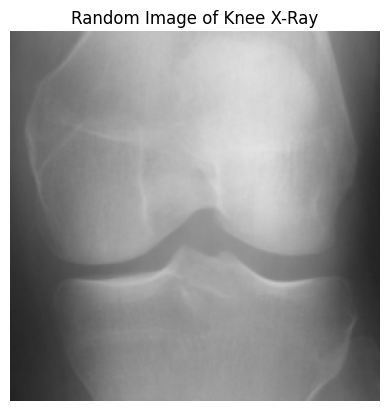

In [10]:
#look at a random image
show_image(test_img,"Random Image of Knee X-Ray")

In [11]:
# check shape and type of image
print(test_img.shape)
print(test_img.dtype)

(224, 224, 3)
uint8


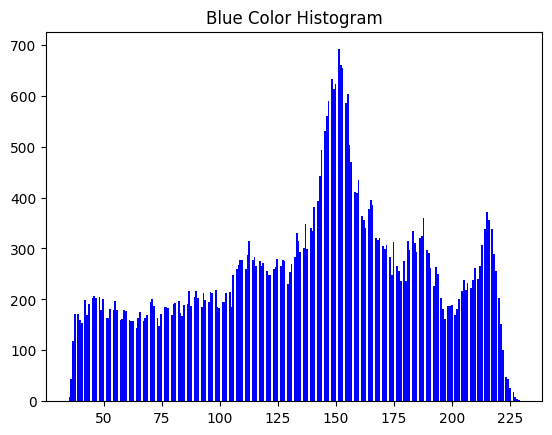

True
True


In [12]:
#histogram of blue color scale
blue=test_img[:, :, 0]
plt.hist(blue.ravel(), bins=256, color='b')
plt.title('Blue Color Histogram')
plt.show()

green=test_img[:, :, 1] #check vector for green color
red=test_img[:, :, 2] #check vector for red color

#Are all three values equal? 
print(np.array_equal(blue,green))
print(np.array_equal(blue,red))

Converting the random image to gray scale

In [13]:
test_gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
test_gray.shape

(224, 224)

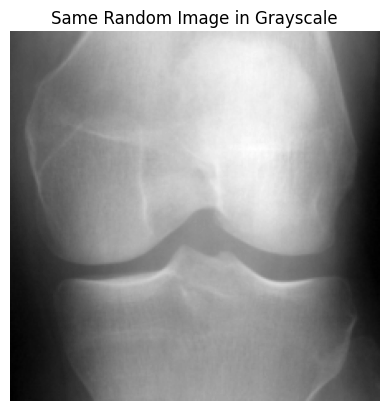

In [14]:
show_image(test_gray,"Same Random Image in Grayscale")

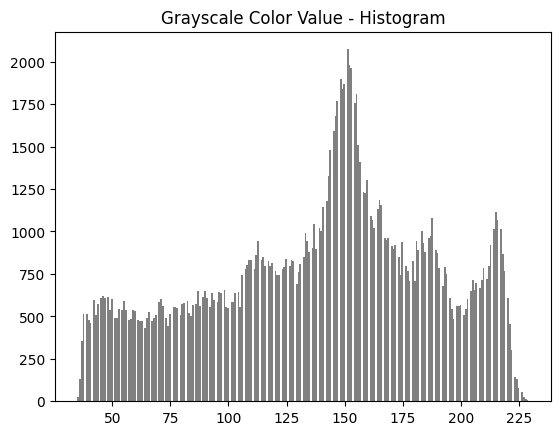

In [15]:
#spread of color depth
plt.hist(test_img.ravel(), bins=256, color='gray')
plt.title('Grayscale Color Value - Histogram')
plt.show()

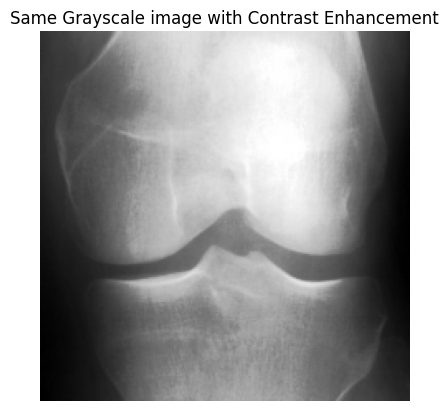

In [16]:
#Histogram Equalization
show_image(cv2.equalizeHist(test_gray),"Same Grayscale image with Contrast Enhancement")

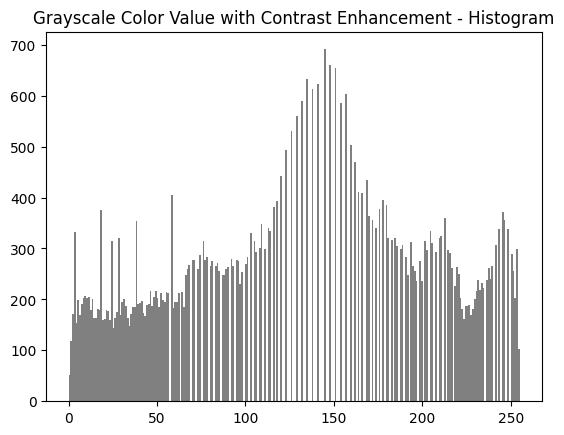

In [17]:
#Histogram Equalization
plt.hist(cv2.equalizeHist(test_gray).ravel(), bins=256, color='gray')
plt.title('Grayscale Color Value with Contrast Enhancement - Histogram')
plt.show()

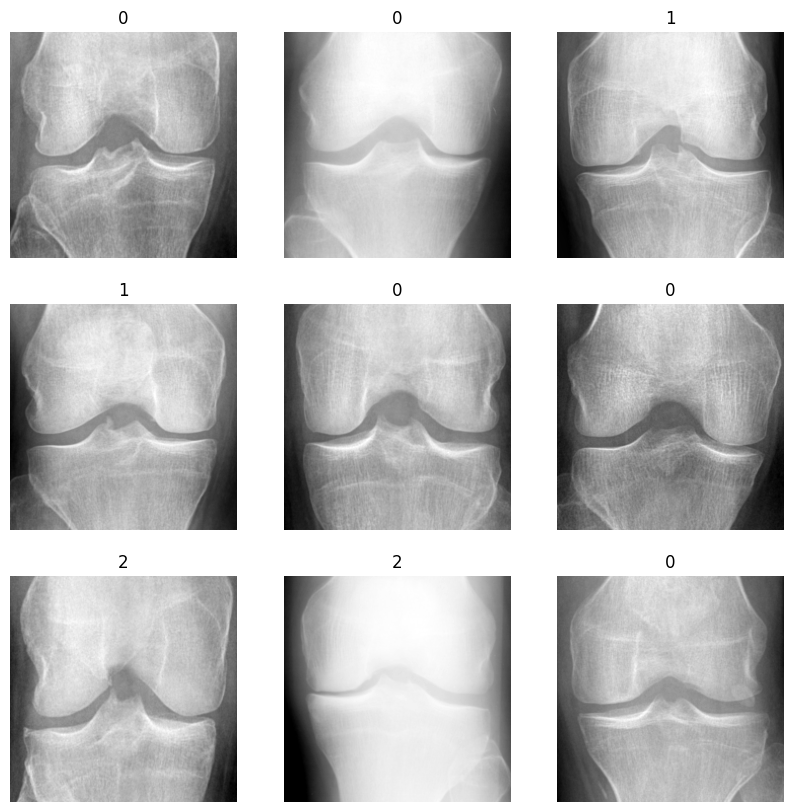

In [19]:
plt.figure(figsize=(10, 10))
for images, labels in training_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]),cmap='gray')
        plt.title(int(labels[i]))
        plt.axis("off")

In [20]:
#set path for directory that contains all 3 train, validation and test sets
directory = '../Data/Raw Data/'

In [21]:
#return files with labels
def fetch_files_from_directory( dir_path ):
  file_dict = {}
  for grade in os.listdir( dir_path ):
    file_dict[grade] = os.listdir(dir_path + '/' + grade)
  return file_dict

In [22]:
#get files for all 3 sets
train_files = fetch_files_from_directory(directory+"train")
val_files = fetch_files_from_directory(directory+"val")
test_files = fetch_files_from_directory(directory+"test")

In [23]:
def plot_distribution(set_of_files, title):
    f, ax = plt.subplots(figsize=(15,5))
    keys = sorted(list(set_of_files.keys()))
    vals = [len(set_of_files[k]) for k in keys]
    sns.barplot(x=keys, y=vals, hue=keys ,palette="Blues_d")
    plt.xlabel('Knee Severity Grade')
    plt.title(title)

    # display values atop bars
    for i, p in enumerate(ax.patches):
        _x = p.get_x() + p.get_width() / 2
        _y = p.get_y() + p.get_height() + (p.get_height() * 0.015)
        value = '{:.0f}'.format(p.get_height())
        ax.text(_x, _y, value, ha="center")

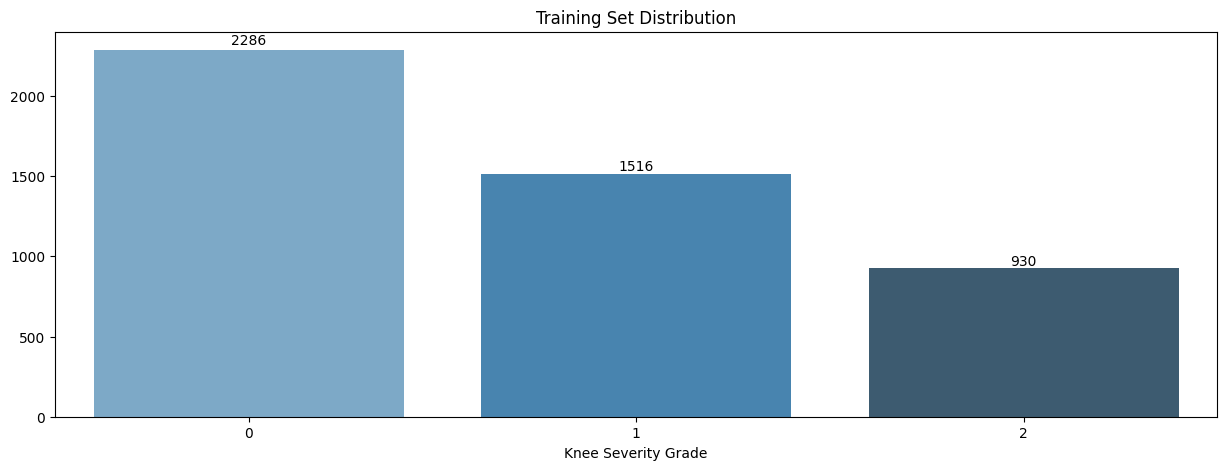

In [24]:
plot_distribution(train_files, 'Training Set Distribution')

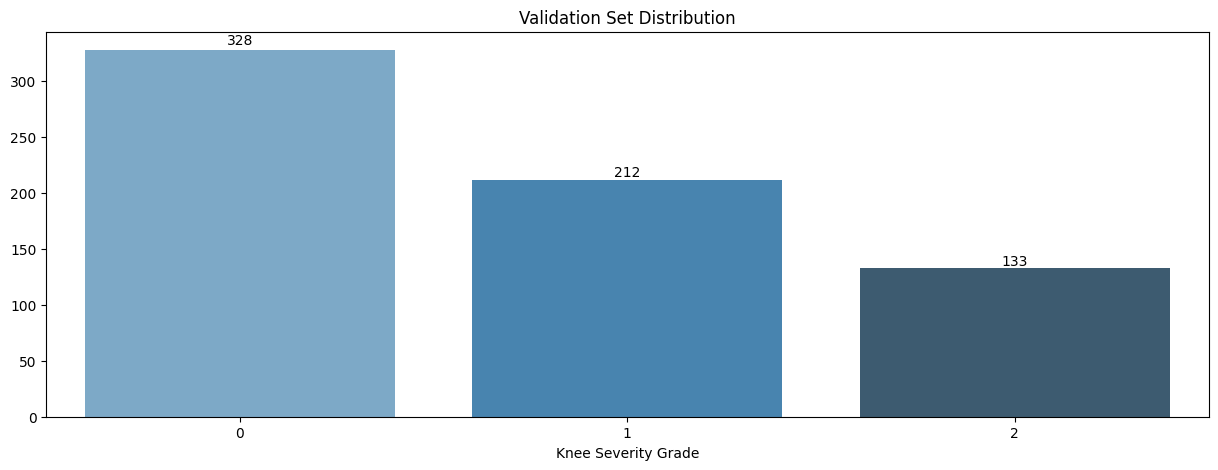

In [25]:
plot_distribution(val_files, 'Validation Set Distribution')

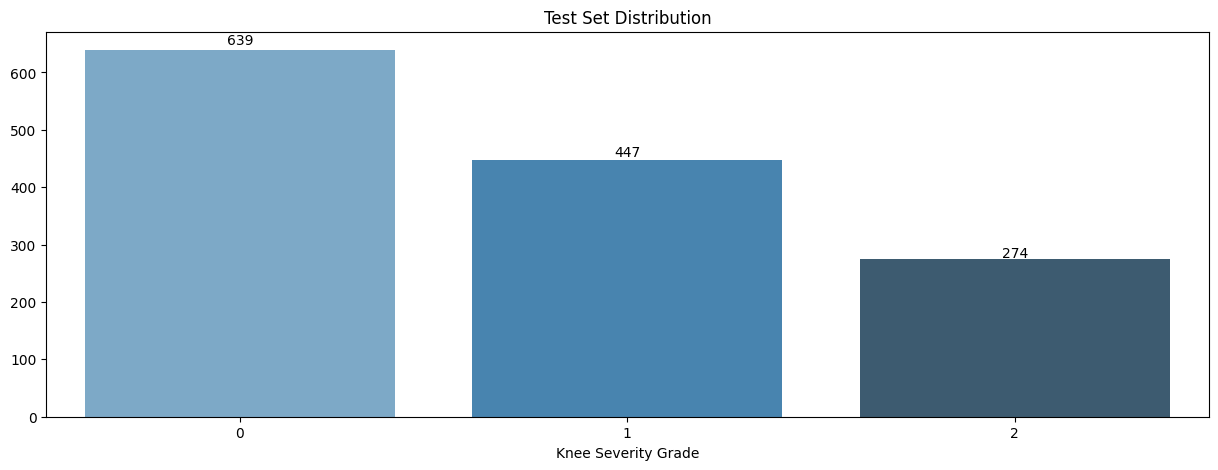

In [26]:
plot_distribution(test_files, 'Test Set Distribution')

# 3. Preprocessing

In [27]:
# Initiate ImageDataGenerators  and rescale images
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [28]:
#Load training files
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    seed=10
)

Found 4732 images belonging to 3 classes.


In [29]:
# load validation files
val_generator = train_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    seed=10
)

Found 673 images belonging to 3 classes.


In [30]:
# load test files
test_generator = train_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    seed=10,
    shuffle = False #setting shuffle as False to compare predicted vs actual values without index issues 
    
)

Found 1360 images belonging to 3 classes.


In [31]:
#Calculate weights for three categories which will be used during modeling
weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_generator.classes), y=train_generator.classes)
class_weight_dictionary = dict(zip(np.unique(train_generator.classes), weights))
print(class_weight_dictionary)

{0: 0.689997083697871, 1: 1.040457343887423, 2: 1.696057347670251}


# 4. Modeling

## 4.1 CNN Model

In [32]:
early_stopping_monitor = EarlyStopping(patience = 2) #callback to stop fit if there is no improvement after 2 subsequential epochs

cnn_model = Sequential()
cnn_model.add(Input(shape=(224,224, 3)))
cnn_model.add(Conv2D(32, (3, 3), activation='relu'))
cnn_model.add(Conv2D(32, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Flatten())  #collapse to 1D

cnn_model.add(Dense(512,activation='relu')) 
cnn_model.add(Dense(3,activation='softmax')) #final 3-way classification, predict class

cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 220, 220, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 108, 108, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 106, 106, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 179776)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    92,045,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,112,931 (351.38 MB)

 Trainable params: 92,112,931 (351.38 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Training CNN model:

In [35]:
cnn_hist = cnn_model.fit(train_generator
                         , epochs=20
                         , validation_data=val_generator
                         , callbacks=[early_stopping_monitor]
                         , class_weight = class_weight_dictionary
                        )

Epoch 1/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.3320 - loss: 1.2955 - val_accuracy: 0.1976 - val_loss: 1.1081
Epoch 2/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.3853 - loss: 1.0991 - val_accuracy: 0.1976 - val_loss: 1.0995
Epoch 3/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.2897 - loss: 1.1107 - val_accuracy: 0.4874 - val_loss: 1.0953
Epoch 4/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.4347 - loss: 1.0994 - val_accuracy: 0.3150 - val_loss: 1.0974
Epoch 5/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.3237 - loss: 1.1098 - val_accuracy: 0.1976 - val_loss: 1.0997


Plotting training and validation results for CNN Model:

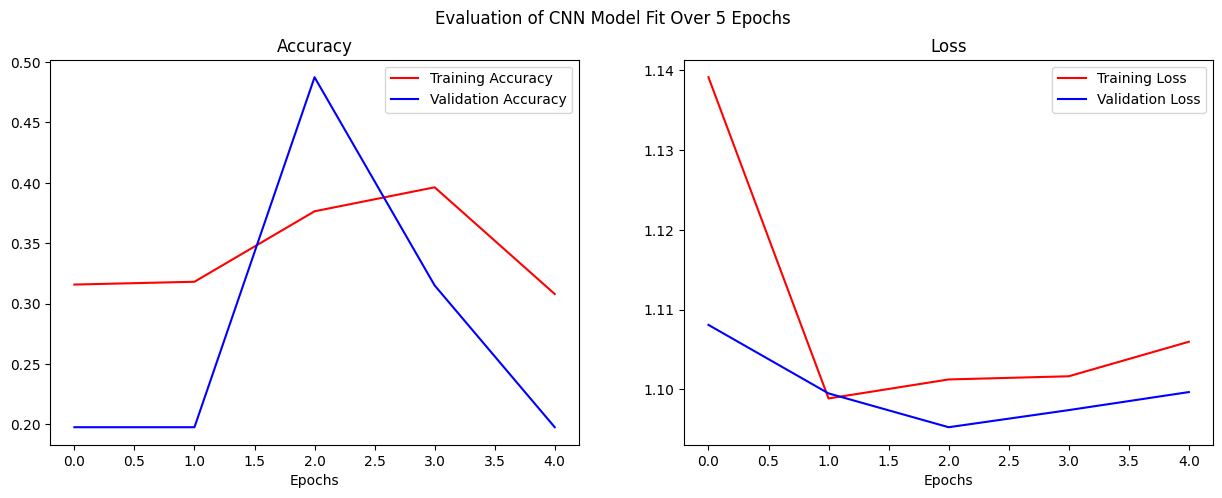

In [36]:
# Plot model fitting (adapted from Deep Learning With Python (Chollet))
h=cnn_hist.history
epochs = range(len(h['accuracy']))
fig,ax=plt.subplots(1,2,figsize=(15,5))
ax[0].plot(epochs, h['accuracy'], 'r', label='Training Accuracy')
ax[0].plot(epochs, h['val_accuracy'], 'b', label='Validation Accuracy')
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].legend()
ax[1].plot(epochs, h['loss'], 'r', label='Training Loss')
ax[1].plot(epochs, h['val_loss'], 'b', label='Validation Loss')
ax[1].set_title('Loss')
ax[1].set_xlabel('Epochs')
ax[1].legend()
plt.suptitle('Evaluation of CNN Model Fit Over {} Epochs'.format(len(h['accuracy'])));

Model stopped after 5 runs as validation accuracy went lower after 4th and 5th run

## 4.2 DenseNet201 Model

In [37]:
densenet_model = DenseNet201(
    include_top=False, # Leave out the last fully connected layer as default is 1000 classes while we have 3
    weights="imagenet",
    input_shape=(224,224, 3),
    classifier_activation="softmax",
)

# densenet_model.summary() #commented out summary as it is shown at the end after saving and loading it as final model

In [38]:
for layer in densenet_model.layers:
    layer.trainable = False #turning off layer training as it is a pretrained model

In [39]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(densenet_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final layer for classification output
x = layers.Dense(3, activation='softmax')(x)

dense_model = tf.keras.models.Model(densenet_model.input, x)

dense_model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])

Train our pre-trained DenseNet201 model

In [40]:
dense_hist = dense_model.fit(train_generator
                         , epochs=20
                         , validation_data=val_generator
                         , callbacks=[early_stopping_monitor]
                         , class_weight = class_weight_dictionary
                        )

Epoch 1/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 363s 2s/step - accuracy: 0.4942 - loss: 8.2013 - val_accuracy: 0.6181 - val_loss: 0.8405
Epoch 2/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 338s 2s/step - accuracy: 0.5877 - loss: 0.8515 - val_accuracy: 0.6568 - val_loss: 0.7556
Epoch 3/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 327s 2s/step - accuracy: 0.5839 - loss: 0.8398 - val_accuracy: 0.6315 - val_loss: 0.7872
Epoch 4/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 329s 2s/step - accuracy: 0.5774 - loss: 0.8175 - val_accuracy: 0.6597 - val_loss: 0.7959


Plotting training and validation results for DenseNet Model:

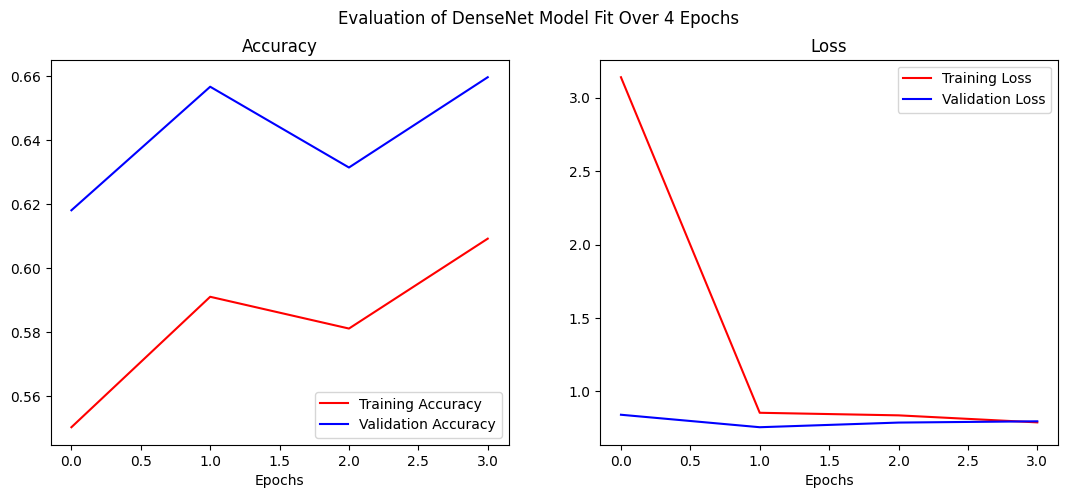

In [41]:
# Plot model fitting
h=dense_hist.history
epochs = range(len(h['accuracy']))
fig,ax=plt.subplots(1,2,figsize=(13,5))
ax[0].plot(epochs, h['accuracy'], 'r', label='Training Accuracy')
ax[0].plot(epochs, h['val_accuracy'], 'b', label='Validation Accuracy')
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].legend()
ax[1].plot(epochs, h['loss'], 'r', label='Training Loss')
ax[1].plot(epochs, h['val_loss'], 'b', label='Validation Loss')
ax[1].set_title('Loss')
ax[1].set_xlabel('Epochs')
ax[1].legend()
plt.suptitle('Evaluation of DenseNet Model Fit Over {} Epochs'.format(len(h['accuracy'])));

# 5. Model Selection

In [42]:
# Check accuracy on new data
test_accuracy = dense_model.evaluate(test_generator)
print('The testing accuracy is :',round(test_accuracy[1]*100,2), '%')

43/43 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.6817 - loss: 0.8385
The testing accuracy is : 67.06 %


In [43]:
#Getting model predictions on unseen test data
y_pred = dense_model.predict(test_generator,verbose=1)
y_pred=np.argmax(y_pred,axis=1) #converting to our labels

43/43 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step


In [44]:
# Get actual labels for test data
y_true = test_generator.labels

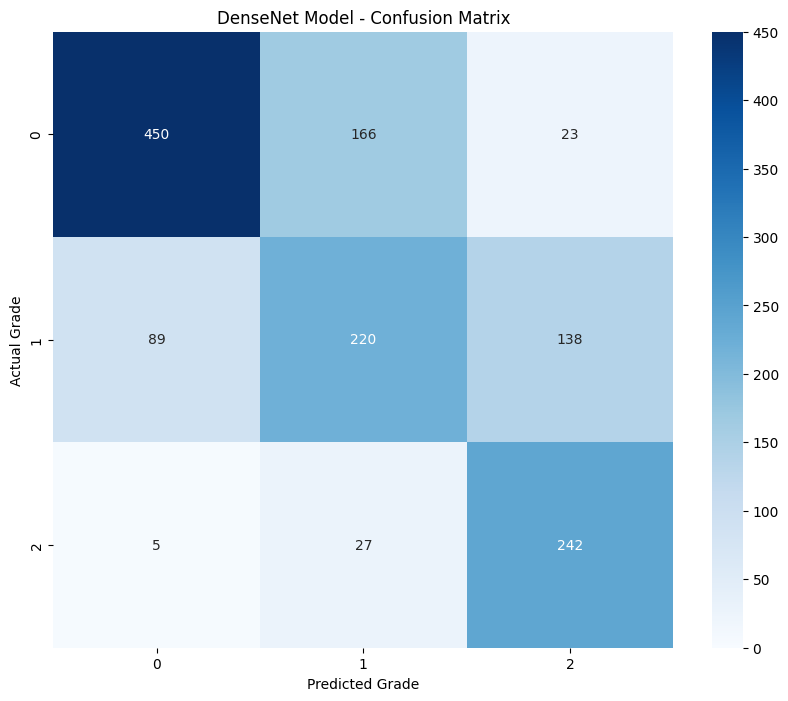

In [45]:
#create and plot confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(10, 8))
_ = sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')
plt.xlabel('Predicted Grade')
plt.ylabel('Actual Grade')
_ = plt.title('DenseNet Model - Confusion Matrix')

The model does a good job identifying High Risk cases with a Recall score of 0.88.
The low-risk cases seem to be most confusing for the model, performance can be improved by increasing amount of training data or focusing on key label and converting problem into a binary problem.

In [46]:
#create and print classification report
print("Dense Model - Classification Report:")
clr = classification_report(test_generator.classes, y_pred, zero_division=0)
print(clr)

Dense Model - Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.70      0.76       639
           1       0.53      0.49      0.51       447
           2       0.60      0.88      0.71       274

    accuracy                           0.67      1360
   macro avg       0.65      0.69      0.66      1360
weighted avg       0.68      0.67      0.67      1360



In [48]:
# Identify misclassified images and create a function to plot them
misclassified_indices = np.where(y_pred != y_true)[0]
class_labels = list(test_generator.class_indices.keys())

# Plot misclassified images
def plot_misclassified_images(misclassified_indices, true_classes, predicted_classes, class_labels, generator):
    fig, axes = plt.subplots(3, 3,figsize=(10, 10))  # Adjust the grid size as needed
    axes = axes.ravel()

    for i in range(9): # Plot 25 misclassified images
        if i < len(misclassified_indices):
            index = misclassified_indices[i]
            image = generator[index][0][0]  # Get the image
            true_label = class_labels[true_classes[index]]
            predicted_label = class_labels[predicted_classes[index]]
            
            axes[i].imshow(image)
            axes[i].set_title(f"True: {true_label}\nPred: {predicted_label}")
            axes[i].axis('off')
        else:
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()

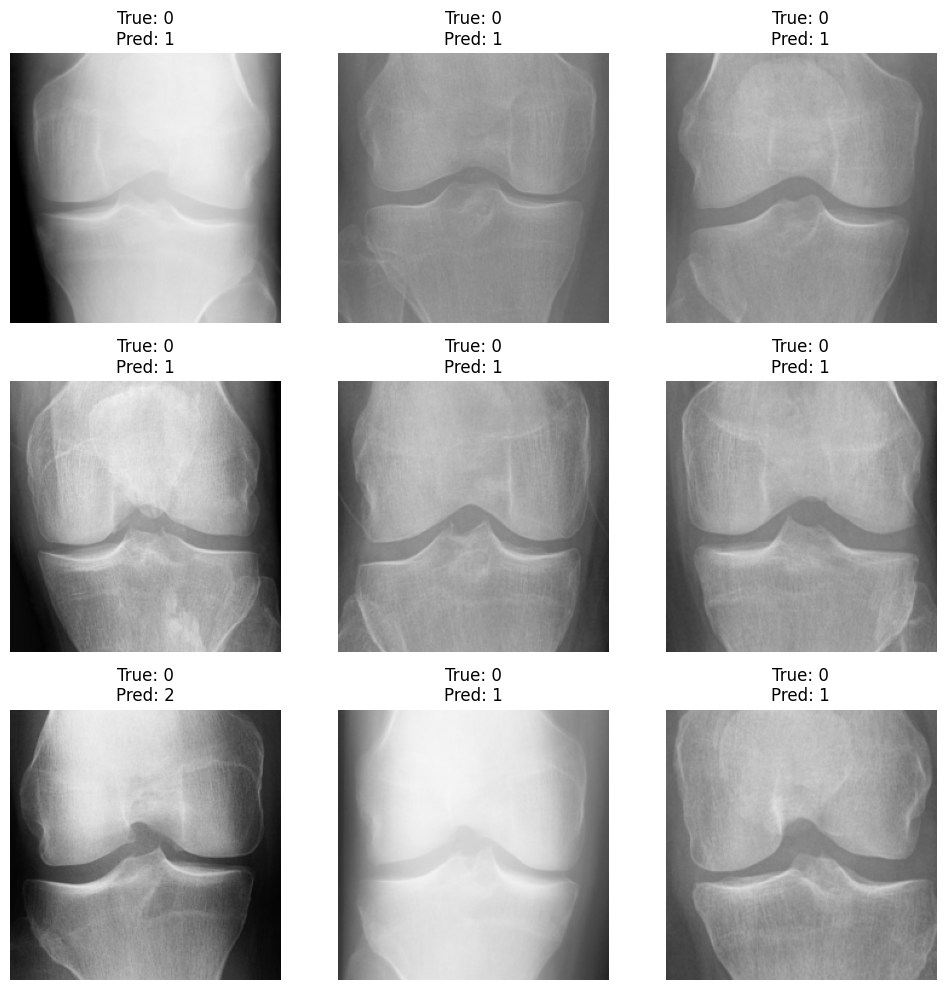

In [51]:
#plot misclassified images with actual and predicted label
plot_misclassified_images(misclassified_indices, y_true, y_pred, class_labels, test_generator)

### Save Final Model

In [52]:
dense_model.save('models/image_classifier.keras')

In [53]:
loaded_model = load_model('models/image_classifier.keras')

In [54]:
#checking loaded model
loaded_model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 162,835,019 (621.17 MB)

 Trainable params: 48,171,011 (183.76 MB)

 Non-trainable params: 18,321,984 (69.89 MB)

 Optimizer params: 96,342,024 (367.52 MB)